In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv("geocoded.csv")
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12242 entries, 0 to 12241
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    12242 non-null  int64  
 1   bed             12242 non-null  float64
 2   bath            12242 non-null  float64
 3   acre_lot        12242 non-null  float64
 4   zip_code        12242 non-null  float64
 5   house_size      12242 non-null  float64
 6   prev_sold_date  12242 non-null  object 
 7   price           12242 non-null  float64
 8   prev_sold_year  12242 non-null  int64  
 9   zip_code_str    12242 non-null  int64  
 10  latitude        12242 non-null  float64
 11  longitude       12242 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 1.1+ MB


In [4]:
outliers_df.head()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude
0,0,3.0,2.0,2.02,12521.0,1600.0,2021-11-24,425000.0,2021,12521,42.171335,-73.650487
1,1,4.0,2.0,0.24,12521.0,1239.0,2018-02-01,225000.0,2018,12521,42.171335,-73.650487
2,2,3.0,3.0,0.09,12521.0,1320.0,2020-02-28,995000.0,2020,12521,42.171335,-73.650487
3,3,3.0,3.0,5.00,12521.0,2517.0,2017-05-30,895000.0,2017,12521,42.171335,-73.650487
4,4,3.0,2.0,1.20,12546.0,1350.0,2018-08-31,375000.0,2018,12546,41.948000,-73.523349


In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

10023.0

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [7]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 3689 to 3838
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    150 non-null    int64  
 1   bed             150 non-null    float64
 2   bath            150 non-null    float64
 3   acre_lot        150 non-null    float64
 4   zip_code        150 non-null    float64
 5   house_size      150 non-null    float64
 6   prev_sold_date  150 non-null    object 
 7   price           150 non-null    float64
 8   prev_sold_year  150 non-null    int64  
 9   zip_code_str    150 non-null    int64  
 10  latitude        150 non-null    float64
 11  longitude       150 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 15.2+ KB


In [8]:
#      "data":one_zipcode_df,
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","latitude","longitude","zip_code"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = outliers_df
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,latitude,longitude,zip_code
3834,0.158628,0.278238,-0.197783,-0.097337,0.013886,2017,40.775921,-73.982607,10023.0
3835,-0.974429,-0.739706,-0.197783,-0.097337,-0.230905,2017,40.775921,-73.982607,10023.0
3836,0.158628,0.278238,-0.197783,-0.097337,-0.106920,2019,40.775921,-73.982607,10023.0
3837,0.158628,0.278238,-0.197783,-0.097337,-0.361248,2019,40.775921,-73.982607,10023.0
3838,1.291685,-0.739706,-0.197783,-0.097337,-0.908053,2017,40.775921,-73.982607,10023.0


In [9]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.170108
bed               0.626874
bath              0.909782
house_size        0.798127
prev_sold_year   -0.017182
price             1.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Correlation Between Variables')

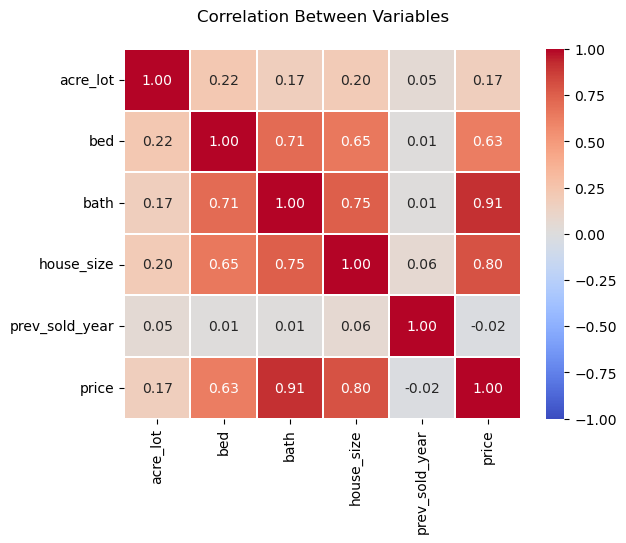

In [10]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

In [11]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'house_size']


In [12]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

In [13]:
X = normalize_df[savefeatures]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [14]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [15]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

In [16]:
adaboost_gscv = GridSearchCV(AdaBoostRegressor(random_state=0, n_estimators=100), {})
adaboost_gscv_model = adaboost_gscv.fit(X_train, y_train)
adaboost_predict = adaboost_gscv.predict(X_test)

In [17]:
results = print_more_stuff("Ada Boost Regressor", y_test, adaboost_predict, adaboost_gscv)
results_dict_append(results)

Ada Boost Regressor EVS = 0.713502117
Ada Boost Regressor MSE = 0.262645
Ada Boost Regressor MAE = 0.373217
Ada Boost Regressor R2 = 0.692167
Ada Boost Regressor Fit Time = 0.006305551528930664


In [18]:
gbr_gscv = GridSearchCV(GradientBoostingRegressor(random_state=0), {})
gbr_gscv_model = gbr_gscv.fit(X_train, y_train)
gbr_predict = gbr_gscv.predict(X_test)

In [19]:
results = print_more_stuff("Gradient Boosting Regressor", y_test, gbr_predict, gbr_gscv)
results_dict_append(results)

Gradient Boosting Regressor EVS = 0.795106974
Gradient Boosting Regressor MSE = 0.174820
Gradient Boosting Regressor MAE = 0.315570
Gradient Boosting Regressor R2 = 0.795102
Gradient Boosting Regressor Fit Time = 0.018778276443481446


In [20]:
rfr_gscv = GridSearchCV(RandomForestRegressor(max_depth=2, random_state=0), {})
rfr_gscv_model = rfr_gscv.fit(X_train, y_train)
rfr_predict = rfr_gscv.predict(X_test)

In [21]:
results = print_more_stuff("Random Forest Regressor", y_test, rfr_predict, rfr_gscv)
results_dict_append(results)

Random Forest Regressor EVS = 0.758725199
Random Forest Regressor MSE = 0.207866
Random Forest Regressor MAE = 0.366123
Random Forest Regressor R2 = 0.756371
Random Forest Regressor Fit Time = 0.057838964462280276


In [22]:
histgbr_gscv = GridSearchCV(HistGradientBoostingRegressor(), {})
histgbr_gscv_model = histgbr_gscv.fit(X_train, y_train)
histgbr_predict = histgbr_gscv.predict(X_test)

In [23]:
results = print_more_stuff("Hist Gradient Boosting Regressor", y_test, histgbr_predict, histgbr_gscv)
results_dict_append(results)

Hist Gradient Boosting Regressor EVS = 0.721259049
Hist Gradient Boosting Regressor MSE = 0.237900
Hist Gradient Boosting Regressor MAE = 0.344220
Hist Gradient Boosting Regressor R2 = 0.721169
Hist Gradient Boosting Regressor Fit Time = 0.07928967475891113


In [24]:
adaboost_predict_df = pd.DataFrame(adaboost_predict).reset_index()
adaboost_predict_df.rename(columns={0: "prediction"},inplace=True)

gbr_predict_df = pd.DataFrame(gbr_predict).reset_index()
gbr_predict_df.rename(columns={0: "prediction"},inplace=True)

rfr_predict_df = pd.DataFrame(rfr_predict).reset_index()
rfr_predict_df.rename(columns={0: "prediction"},inplace=True)

histgbr_predict_df = pd.DataFrame(histgbr_predict).reset_index()
histgbr_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

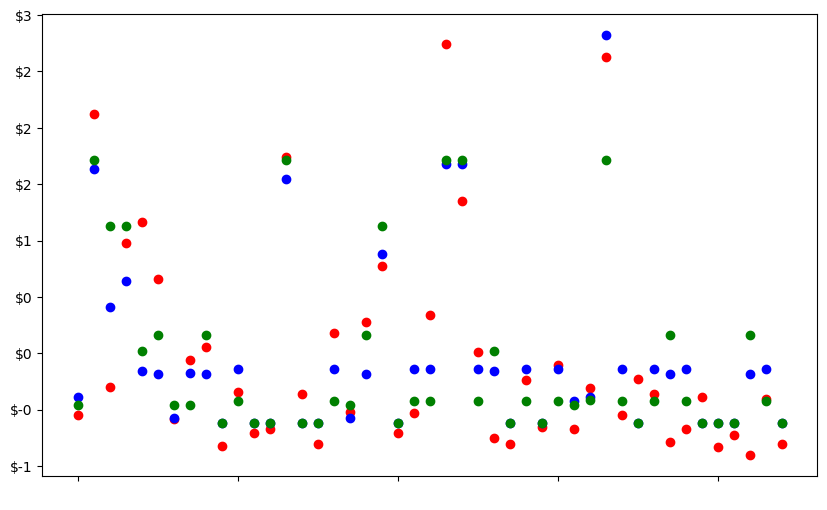

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(gbr_predict_df.index,gbr_predict_df["prediction"], color="blue")
plt.scatter(histgbr_predict_df.index,histgbr_predict_df["prediction"], color="green")
#plt.scatter(rfr_predict_df.index,adaboost_predict_df["prediction"], color="black")
#plt.scatter(rfr_predict_df.index,rfr_predict_df["prediction"], color="black")
plt.show()

In [26]:
results_dict

{'model': ['Ada Boost Regressor',
  'Gradient Boosting Regressor',
  'Random Forest Regressor',
  'Hist Gradient Boosting Regressor'],
 'explained variance score': ['0.713502117',
  '0.795106974',
  '0.758725199',
  '0.721259049'],
 'mae score': ['0.373217', '0.315570', '0.366123', '0.344220'],
 'mse score': ['0.262645', '0.174820', '0.207866', '0.237900'],
 'r2 score': ['0.692167', '0.795102', '0.756371', '0.721169'],
 'mean fit time': [0.006305551528930664,
  0.018778276443481446,
  0.057838964462280276,
  0.07928967475891113]}

In [27]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ada Boost Regressor,0.713502117,0.373217,0.262645,0.692167,0.006306
Gradient Boosting Regressor,0.795106974,0.315570,0.174820,0.795102,0.018778
Random Forest Regressor,0.758725199,0.366123,0.207866,0.756371,0.057839
Hist Gradient Boosting Regressor,0.721259049,0.344220,0.237900,0.721169,0.079290
